# Data Science Project: Battle of London Boroughs

## Finding suitable locations to open a car wash in London, UK
## Sergej Dzigajev (February 2021)

### Contents
* Introduction
* Data
* Methodology
* Analysis
* Results
* Conclusion
* References
<br>

### Introduction
Imagine for a moment that an investor is looking to open a car wash in London, United Kingdom. The investor crunched all of the numbers and on paper it is looking like a good business idea. However, the question now stands about the location. What would be the best place to open a new car wash to maximise return on investment? There is already thriving competition present in the city, and the investor wants to find out which one of Greater London's 32 Boroughs would be the optimum place. <br>
 
To answer this question, the investor turns to the field of **Data Science** in order to explore all of the Boroughs from a deep analytical point of view. The main objective is to explore what each Borough contains, and what each Borough lacks. A perfect outcome would be to find an area that 1) isn't too crowded with competition, 2) has a lot of passing traffic and 3) relatively large population, and then to open up a new car wash in that area.

### Data 
    
To answer the main question of this report, data will be collected from several sources. First, a list of all 32 Greater London Boroughs (excluding city of London as it is predominantly a business district), including latitude and longitude positions and the population of each Borough which can be scraped from the Wikipedia page.
    
Next, it is necessary to identify the number and locations of existing car washes in London. Foursquare API is going to be used to help find and extract this information. The API allows one to search for businesses and venues around a given geographic point (like the Borough information from Wikipedia) and find out how many and what types of businesses are in that area. This data will then be extrapolated and prepared for further analysis.
    
In addition, vehicle traffic information (volume) of each Borough will be used from UK's Department of Transport. Data figures give the total volume of traffic across each local authority for the whole year. This will be used in order to assess how much 'potential' traffic there is in each Borough for a given car wash.    

For further sources of data please refer to the References section.   

### Methodology

There are several algorithms that can be used to cluster location data. For this particular exercise, K-means clustering is going to be used to help group car wash locations and analyse the best potential candidate. 

K-means aims to partition the observations into a predefined number of clusters (k) in which each point belongs to the cluster with the nearest mean. It starts by randomly selecting k centroids and assigning the points to the closest cluster, then it updates each centroid with the mean of all points in the cluster through iterating the data. This algorithm is convenient when you need to get a precise number of groups, and it’s more appropriate for a small number of even clusters.

In order to define the right k, Elbow Method is going to be used by plotting the variance as a function of the number of clusters and picking the k that flattens the curve.
    
The main open source Python libraries that are used are the following:
    
**Data Analysis and Manipulation**<br>  
* Pandas
* SciPy
* NumPy
    
**Data Visualisation**<br>    
* Matplotlib
* Seaborn
* Folium 
    
**Machine Learning**<br>  
* Scikit-Learn

### Analysis

In [2]:
#---imports---
import pandas as pd
import re
from geopy.geocoders import Nominatim
import folium
import requests
import folium.plugins as plugins
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, cluster
from sklearn.cluster import KMeans
import numpy as np
import scipy

#### Scrape and parse London Boroughs from Wikipedia page using Pandas.

In [3]:
url='https://en.wikipedia.org/wiki/List_of_London_boroughs'

df=pd.read_html(url, header=0)[0]

df

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2019 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,212906,".mw-parser-output .geo-default,.mw-parser-outp...",25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,395896,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,248287,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,329771,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,332336,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20
5,Camden,NaN,NaN,Camden London Borough Council,Labour,"Camden Town Hall, Judd Street",8.40,270029,51°31′44″N 0°07′32″W﻿ / ﻿51.5290°N 0.1255°W,11
6,Croydon,NaN,NaN,Croydon London Borough Council,Labour,"Bernard Weatherill House, Mint Walk",33.41,386710,51°22′17″N 0°05′52″W﻿ / ﻿51.3714°N 0.0977°W,19
7,Ealing,NaN,NaN,Ealing London Borough Council,Labour,"Perceval House, 14-16 Uxbridge Road",21.44,341806,51°30′47″N 0°18′32″W﻿ / ﻿51.5130°N 0.3089°W,13
8,Enfield,NaN,NaN,Enfield London Borough Council,Labour,"Civic Centre, Silver Street",31.74,333794,51°39′14″N 0°04′48″W﻿ / ﻿51.6538°N 0.0799°W,30
9,Greenwich [note 2],[note 3],Royal,Greenwich London Borough Council,Labour,"Woolwich Town Hall, Wellington Street",18.28,287942,51°29′21″N 0°03′53″E﻿ / ﻿51.4892°N 0.0648°E,22


#### Clean the data.

In [4]:
#copy the necessary columns
df = df[['Borough','Population (2019 est)[1]']].copy()
#delete the unnecessary notes in Borough rows
df['Borough'] = df['Borough'].str.replace(r"\[.*?\]","")
#rename the column for simplicity
df = df.rename(columns={'Population (2019 est)[1]': 'Population'})
#remove any white space before or after string for future manipulation
df['Borough'] = df['Borough'].str.strip()
df

,Borough,Population
0,Barking and Dagenham,212906
1,Barnet,395896
2,Bexley,248287
3,Brent,329771
4,Bromley,332336
5,Camden,270029
6,Croydon,386710
7,Ealing,341806
8,Enfield,333794
9,Greenwich,287942


#### Fetch Latitude and Longitude using Nominatim

In [5]:
#Extract decimal lat long using Nominatim

#add London prefix to make sure it's the correct Address (similar names of places in US or Canada!)
df['Borough'] = df['Borough'].astype(str) + ', London'
df['Latitude'] = None
df['Longitude'] = None
locator = Nominatim(user_agent="myGeocoder")
for i in range(len(df)):
    location = locator.geocode(df.loc[i,'Borough'])
    df.loc[i,'Latitude'] = location.latitude   
    df.loc[i,'Longitude'] = location.longitude
#remove London prefix 
df['Borough'] = df['Borough'].str.replace(', London', '')
df

,Borough,Population,Latitude,Longitude
0,Barking and Dagenham,212906,51.5541,0.150504
1,Barnet,395896,51.6531,-0.200226
2,Bexley,248287,51.4417,0.150488
3,Brent,329771,51.5638,-0.27576
4,Bromley,332336,51.4028,0.0148142
5,Camden,270029,51.5423,-0.13956
6,Croydon,386710,51.3713,-0.101957
7,Ealing,341806,51.5127,-0.305195
8,Enfield,333794,51.6521,-0.0810175
9,Greenwich,287942,51.4821,-0.0045417


#### Use geopy library to get the latitude and longitude values of London to build a map.

In [6]:
#Use geopy library to get the latitude and longitude values of London to build a map.
address = 'London, United Kingdom'
\
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
lon_lat = location.latitude
lon_long = location.longitude
print('The geograpical coordinate of London, UK are {}, {}.'.format(lon_lat, lon_long))

The geograpical coordinate of London, UK are 51.5073219, -0.1276474.


#### Create a Folium Map with London Boroughs

In [7]:
#Create a map of London with neighborhoods superimposed on top.

# create map of London using latitude and longitude values

map_london = folium.Map(location=[lon_lat, lon_long], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(df['Latitude'], df['Longitude'], df['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
map_london

#### Set-up Foursquare

In [8]:
CLIENT_ID = 'T4T0MTD4QWKJ5QO15HL0HCS2M2XY0BKNSOIBTLNWQXJIJOGL' # your Foursquare ID
CLIENT_SECRET = 'NF2GNFZYFARK2HV1ZYHQRMN0MISPUZFDEJWII4YJNJ2R3DQM' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 
RADIUS = 15000
category_id = '4f04ae1f2fb6e1c99f3db0ba'

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: T4T0MTD4QWKJ5QO15HL0HCS2M2XY0BKNSOIBTLNWQXJIJOGL
CLIENT_SECRET:NF2GNFZYFARK2HV1ZYHQRMN0MISPUZFDEJWII4YJNJ2R3DQM


#### Method to extract car wash data

In [9]:
#collect car wash data
def getNearbyCarWash(categoryId, boroughs, latitudes, longitudes, radius=7500):
    
    carwash_list=[]
    for borough, lat, lng in zip(boroughs, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            category_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        # return only relevant information for each nearby borough
        carwash_list.append([(
            borough,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['distance'],
            v['venue']['categories'][0]['name']
        ) for v in results])

    nearby_carwash_df = pd.DataFrame([item for venue_list in carwash_list for item in venue_list])
    nearby_carwash_df.columns = [
                  'Borough Name',
                  'Latitude',
                  'Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Distance from Borough city centre',
                  'Venue Category']
    print('Finished')
    return(nearby_carwash_df)

In [10]:
carwash_venues_df = getNearbyCarWash(category_id, boroughs=df['Borough'], latitudes=df['Latitude'], longitudes=df['Longitude'])

Finished


In [11]:
#check the number of car washes
carwash_venues_df.shape

(368, 8)

#### Since we set our radius to 7.5km around each Borough centre, there will be duplicates. Remove them:

In [12]:
# Examine all duplicate rows based on one column
duplicateRowsDF = carwash_venues_df[carwash_venues_df.duplicated(['Venue Latitude'])]
print("Duplicate Rows based on a single column are:", duplicateRowsDF, sep='\n')

Duplicate Rows based on a single column are:
    Borough Name   Latitude  Longitude                    Venue  \
31         Brent  51.563826  -0.275760            Hand Car Wash   
34         Brent  51.563826  -0.275760            Hand Car Wash   
45       Bromley  51.402805   0.014814        Olley's Posh Wosh   
47        Camden  51.542305  -0.139560    The American Car Wash   
52        Camden  51.542305  -0.139560                    Shell   
..           ...        ...        ...                      ...   
363  Westminster  51.500444  -0.126540    The American Car Wash   
364  Westminster  51.500444  -0.126540  H2O Car Wash & Valeting   
365  Westminster  51.500444  -0.126540        Starhand Car Wash   
366  Westminster  51.500444  -0.126540          5 Star Car Wash   
367  Westminster  51.500444  -0.126540                       BP   

     Venue Latitude  Venue Longitude  Distance from Borough city centre  \
31        51.613247        -0.250251                               5777   


In [13]:
#drop these duplicates
carwash_venues_df = carwash_venues_df.drop_duplicates(['Venue Latitude','Venue Longitude'])
carwash_venues_df

,Borough Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Distance from Borough city centre,Venue Category
0,Barking and Dagenham,51.554117,0.150504,BP,51.549951,0.161963,918,Car Wash
1,Barking and Dagenham,51.554117,0.150504,BP,51.565010,0.203570,3867,Car Wash
2,Barking and Dagenham,51.554117,0.150504,Waves Hand Car Wash,51.566331,0.190599,3089,Car Wash
3,Barking and Dagenham,51.554117,0.150504,Ship And Shovel Carwash,51.532009,0.117131,3375,Car Wash
4,Barking and Dagenham,51.554117,0.150504,IMO Car Wash,51.535007,0.103300,3899,Car Wash
...,...,...,...,...,...,...,...,...
222,Kingston upon Thames,51.409627,-0.306262,TheEcoSmart - Car Valeting East London,51.411908,-0.208150,6816,Car Wash
248,Merton,51.410870,-0.188097,IMO Car Wash,51.413672,-0.186490,331,Car Wash
255,Merton,51.410870,-0.188097,BP,51.364920,-0.214090,5424,Car Wash
272,Redbridge,51.576320,0.045410,Chigwell Hand Car Wash,51.597480,0.039001,2396,Car Wash


#### Analyse the final extracted data

In [14]:
#check how many venues were returned for each neighborhood
carwash_venues_df.groupby('Borough Name').count()

,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Distance from Borough city centre,Venue Category
Borough Name,,,,,,,
Barking and Dagenham,10,10,10,10,10,10,10
Barnet,6,6,6,6,6,6,6
Bexley,7,7,7,7,7,7,7
Brent,11,11,11,11,11,11,11
Bromley,9,9,9,9,9,9,9
Camden,9,9,9,9,9,9,9
Croydon,5,5,5,5,5,5,5
Ealing,6,6,6,6,6,6,6
Enfield,6,6,6,6,6,6,6


In [15]:
# Check the categories of venues that were returned for each borough

carwash_venues_df.groupby(['Venue Category']).count()

,Borough Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Distance from Borough city centre
Venue Category,,,,,,,
Auto Garage,1,1,1,1,1,1,1
Car Wash,94,94,94,94,94,94,94
Gas Station,3,3,3,3,3,3,3
Miscellaneous Shop,1,1,1,1,1,1,1


<AxesSubplot:xlabel='Borough Name'>

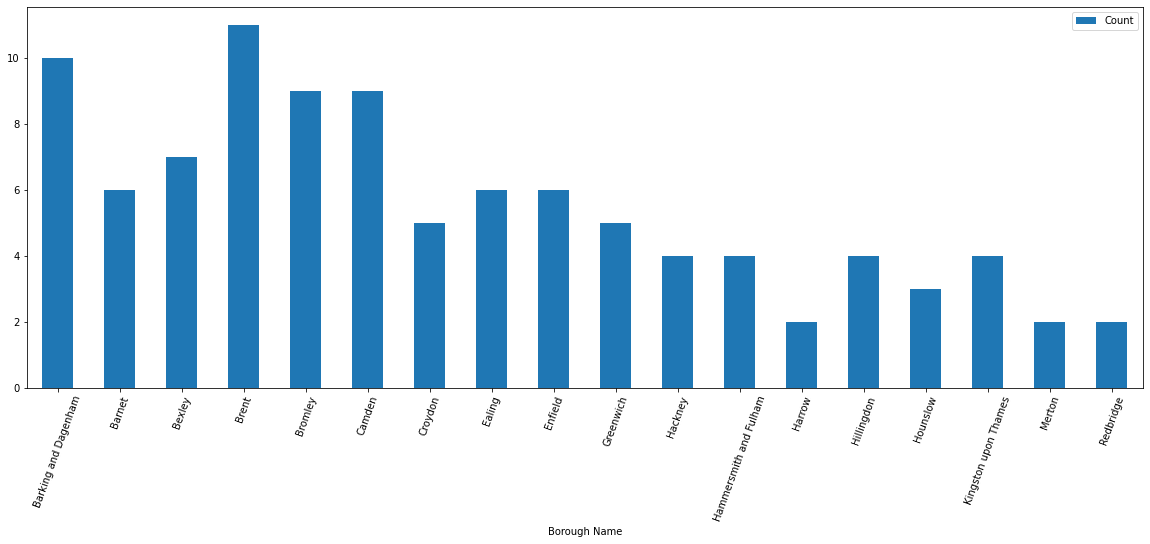

In [16]:
# Sort the data by frequency
sorted_venues = carwash_venues_df.groupby(['Borough Name']).size().reset_index(name='Count')
sorted_venues.columns=['Borough Name','Count']

sorted_venues.plot(x='Borough Name', y='Count', kind='bar', figsize=(20,7), rot=70)

#### Plot existing Car Washes on the map

In [17]:
# add car washes to map
for lat, lng, carwash in zip(carwash_venues_df['Venue Latitude'], carwash_venues_df['Venue Longitude'], carwash_venues_df['Venue']):
    label = '{}'.format(carwash)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='red',
        fill=True,
        fill_color='#ff6666',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
map_london

#### Produce a Heat Map

In [18]:
HeatMap(data=carwash_venues_df[['Venue Latitude','Venue Longitude']].groupby(['Venue Latitude','Venue Longitude']).sum().reset_index().values.tolist(), radius=20, max_zoom=10).add_to(map_london)
map_london

#### Extract traffic volume information from Department for Transport and prepare the data

In [19]:
url = 'http://data.dft.gov.uk/road-traffic/local_authority_traffic.csv'
traffic_df = pd.read_csv(url)
#we only need data for the recent year
traffic_df = traffic_df[traffic_df['year'] == 2019]
#we only need data for each Authority (non-London are included here as well) and traffic volume
traffic_df = traffic_df[['local_authority_name','cars_and_taxis']].copy()
traffic_df.head()

,local_authority_name,cars_and_taxis
0,Aberdeenshire,1.537817e+09
1,Lambeth,3.977109e+08
2,Newcastle upon Tyne,1.006029e+09
3,Tower Hamlets,4.652937e+08
4,St. Helens,7.281754e+08


In [20]:
traffic_df.shape

(205, 2)

In [21]:
traffic_df = traffic_df.rename(columns={'local_authority_name': 'Borough'}) #rename the column
df.columns = df.columns.str.rstrip() #make sure again there is no white space
df_merged = pd.merge(df, traffic_df, on='Borough', how='left') #join our main table with Boroughs on traffic volume dataframe
df_merged

,Borough,Population,Latitude,Longitude,cars_and_taxis
0,Barking and Dagenham,212906,51.5541,0.150504,3.882197e+08
1,Barnet,395896,51.6531,-0.200226,1.016422e+09
2,Bexley,248287,51.4417,0.150488,6.273994e+08
3,Brent,329771,51.5638,-0.27576,5.378248e+08
4,Bromley,332336,51.4028,0.0148142,7.759492e+08
5,Camden,270029,51.5423,-0.13956,2.184910e+08
6,Croydon,386710,51.3713,-0.101957,7.481640e+08
7,Ealing,341806,51.5127,-0.305195,6.879543e+08
8,Enfield,333794,51.6521,-0.0810175,9.518058e+08
9,Greenwich,287942,51.4821,-0.0045417,6.167056e+08


In [22]:
#peform another merge to create a final table for analysis
df_merged = df_merged.rename(columns={'Borough': 'Borough Name'})
df_merged_edit = df_merged[['Borough Name','Population', 'cars_and_taxis']].copy()
df_final = pd.merge(carwash_venues_df, df_merged_edit, on='Borough Name', how='left' ) #perform another join to connect to Car Wash Dataframe
df_final = df_final.drop(['Venue Category'], axis=1) 
df_final['cars_and_taxis'] = df_final['cars_and_taxis'].div(1000000).round(2) #devide by 1m to ready more easily
df_final

,Borough Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Distance from Borough city centre,Population,cars_and_taxis
0,Barking and Dagenham,51.554117,0.150504,BP,51.549951,0.161963,918,212906,388.22
1,Barking and Dagenham,51.554117,0.150504,BP,51.565010,0.203570,3867,212906,388.22
2,Barking and Dagenham,51.554117,0.150504,Waves Hand Car Wash,51.566331,0.190599,3089,212906,388.22
3,Barking and Dagenham,51.554117,0.150504,Ship And Shovel Carwash,51.532009,0.117131,3375,212906,388.22
4,Barking and Dagenham,51.554117,0.150504,IMO Car Wash,51.535007,0.103300,3899,212906,388.22
...,...,...,...,...,...,...,...,...,...
94,Kingston upon Thames,51.409627,-0.306262,TheEcoSmart - Car Valeting East London,51.411908,-0.208150,6816,177507,542.77
95,Merton,51.410870,-0.188097,IMO Car Wash,51.413672,-0.186490,331,206548,351.32
96,Merton,51.410870,-0.188097,BP,51.364920,-0.214090,5424,206548,351.32
97,Redbridge,51.576320,0.045410,Chigwell Hand Car Wash,51.597480,0.039001,2396,305222,681.59


#### Produce histograms to see how data varies

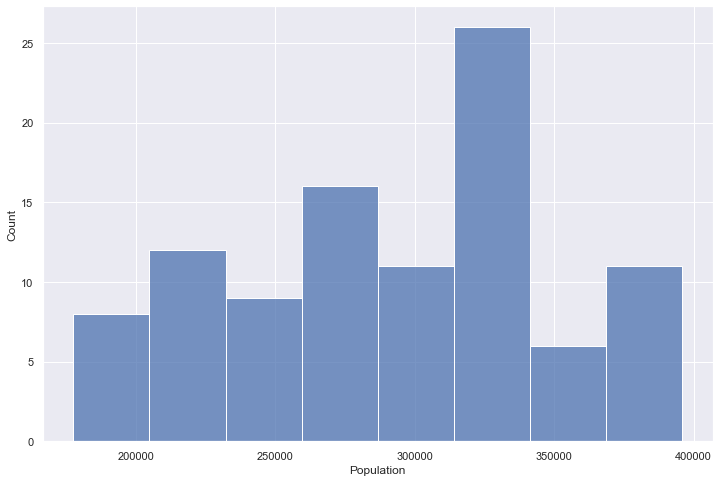

In [23]:
sns.set(rc={'figure.figsize':(12,8)})
ax = sns.histplot(x="Population",data=df_final)

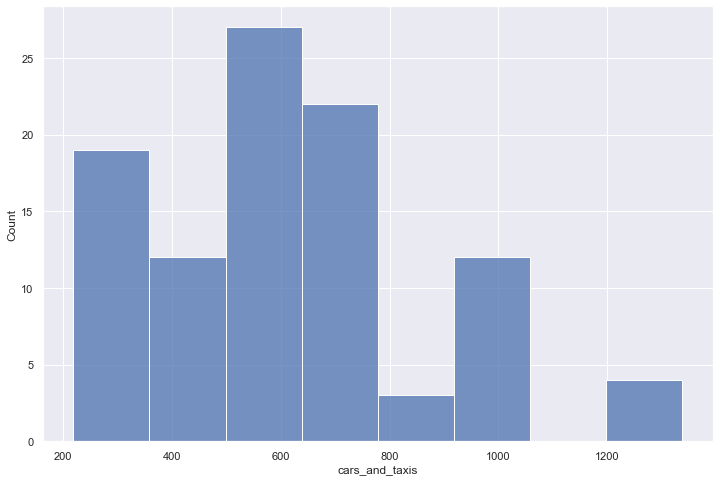

In [24]:
ax = sns.histplot(x="cars_and_taxis",data=df_final)

#### K-means analysis. 

There are several algorithms that can be used to cluster data. 

<u>K-Means</u> aims to partition the observations into a predefined number of clusters (k) in which each point belongs to the cluster with the nearest mean. It starts by randomly selecting k centroids and assigning the points to the closest cluster, then it updates each centroid with the mean of all points in the cluster. This algorithm is convenient when you need the get a precise number of groups, and it’s more appropriate for a small number of even clusters.<br><br>
Here, in order to define the right k, I shall use the Elbow Method: plotting the variance as a function of the number of clusters and picking the k that flats the curve.

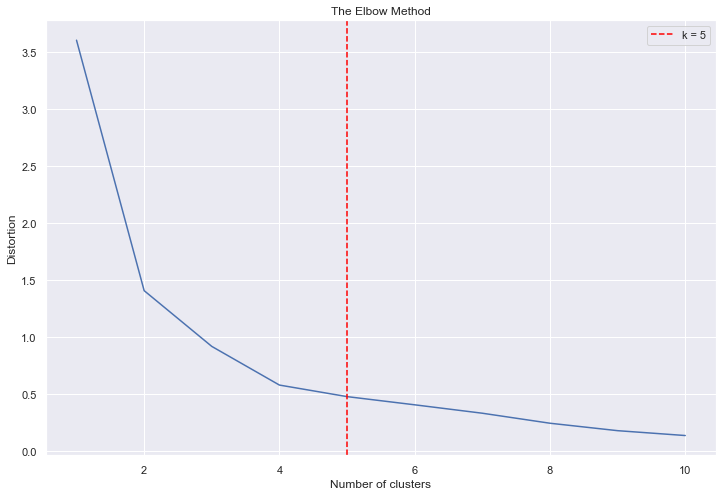

In [25]:
X = df_final[["Latitude","Longitude"]]
max_k = 10
## iterations
distortions = [] 
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_)
## best k: the lowest derivative
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i 
     in np.diff(distortions,2)]))
## plot
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color="red", label="k = "+str(k))
ax.set(title='The Elbow Method', xlabel='Number of clusters', 
       ylabel="Distortion")
ax.legend()
ax.grid(True)
plt.show()

#### K = 5 seems to be the right number of clusters to use. Re-model using k = 5.

In [26]:
k = 5
model = cluster.KMeans(n_clusters=k, init='k-means++')
X = df_final[["Latitude","Longitude"]]
## clustering
df_X = X.copy()
df_X["cluster"] = model.fit_predict(X)
## find real centroids
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, 
                     df_X.drop("cluster", axis=1).values)
df_X["centroids"] = 0
for i in closest:
    df_X["centroids"].iloc[i] = 1
## add clustering info to the original dataset
df_final[["cluster","centroids"]] = df_X[["cluster","centroids"]]
df_final.sample(5)

C:\Users\serge\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Borough Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Distance from Borough city centre,Population,cars_and_taxis,cluster,centroids
35,Bromley,51.402805,0.014814,Esso,51.388977,-0.025777,3212,332336,775.95,0,0
12,Barnet,51.653090,-0.200226,Hand Car Wash,51.613247,-0.250251,5623,395896,1016.42,2,0
7,Barking and Dagenham,51.554117,0.150504,BP,51.573640,0.085850,4974,212906,388.22,3,0
77,Hackney,51.543240,-0.049362,Albanian Car Wash,51.573754,0.017208,5724,281120,250.61,2,0
31,Brent,51.563826,-0.275760,BP,51.521460,-0.354700,7218,329771,537.82,1,0


#### Plot a scatter plot with all of existing Car Washes allocated to individual clusters with their centroid points.

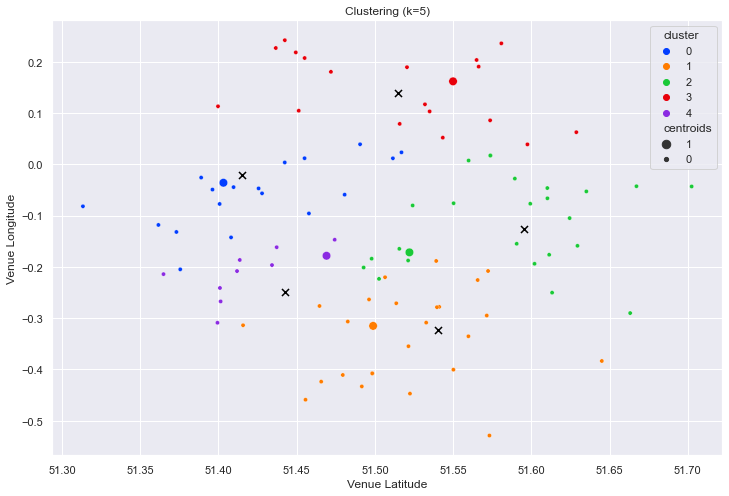

In [27]:
## plot
fig, ax = plt.subplots()
sns.scatterplot(x="Venue Latitude", y="Venue Longitude", data=df_final, 
                palette=sns.color_palette("bright",k),
                hue='cluster', size="centroids", size_order=[1,0],
                legend="brief", ax=ax).set_title('Clustering (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', 
           marker="x")

#### Finally, plot a map with existing clustered Car Washes with a bubble function. The bubble size represents volume of traffic in a particular area.

In [28]:
x, y = "Venue Latitude", "Venue Longitude"
color = "cluster"
size = "cars_and_taxis"
popup = "Venue"
marker = "centroids"
data = df_final.copy()
## create color column
lst_elements = sorted(list(df_final[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in 
              range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: 
                lst_colors[lst_elements.index(x)])
## create size column (scaled)
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))
data["size"] = scaler.fit_transform(
               data[size].values.reshape(-1,1)).reshape(-1)
## initialize the map with the starting location
map_ = folium.Map(location=[lat, lng], tiles="cartodbpositron",
                  zoom_start=11)
## add points
data.apply(lambda row: folium.CircleMarker(
           location=[row[x],row[y]], popup=row[popup],
           color=row["color"], fill=True,
           radius=row["size"]).add_to(map_), axis=1)
## add html legend
legend_html = """<div style="position:fixed; bottom:10px; left:10px; border:2px solid black; z-index:9999; font-size:14px;">&nbsp;<b>"""+color+""":</b><br>"""
for i in lst_elements:
     legend_html = legend_html+"""&nbsp;<i class="fa fa-circle 
     fa-1x" style="color:"""+lst_colors[lst_elements.index(i)]+"""">
     </i>&nbsp;"""+str(i)+"""<br>"""
legend_html = legend_html+"""</div>"""
map_.get_root().html.add_child(folium.Element(legend_html))
## add centroids marker
lst_elements = sorted(list(df_final[marker].unique()))
data[data[marker]==1].apply(lambda row: 
           folium.Marker(location=[row[x],row[y]], 
           popup=row[marker], draggable=False,          
           icon=folium.Icon(color="black")).add_to(map_), axis=1)
## plot the map
map_

It seems that the ML algorithm has split the existing facilities in the following manner:

* Cluster 1: South London
* Cluster 2: West London
* Cluster 3: North London
* Cluster 4: East London
* Cluster 5: South-West London

#### Analyse each cluster.

In [29]:
cluster_1 = df_final.loc[df_final['cluster'] == 0]
cluster_1

,Borough Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Distance from Borough city centre,Population,cars_and_taxis,cluster,centroids
34,Bromley,51.402805,0.014814,BP,51.403212,-0.035880,3520,332336,775.95,0,1
35,Bromley,51.402805,0.014814,Esso,51.388977,-0.025777,3212,332336,775.95,0,0
36,Bromley,51.402805,0.014814,Shell,51.409696,-0.044399,4182,332336,775.95,0,0
37,Bromley,51.402805,0.014814,Leo Hand Car Wash,51.442428,0.003712,4477,332336,775.95,0,0
38,Bromley,51.402805,0.014814,IMO Car Wash,51.396218,-0.049229,4507,332336,775.95,0,0
39,Bromley,51.402805,0.014814,BP,51.427894,-0.056504,5684,332336,775.95,0,0
40,Bromley,51.402805,0.014814,Sydenham Hand CarWash,51.425696,-0.046902,4985,332336,775.95,0,0
41,Bromley,51.402805,0.014814,BP,51.400804,-0.077238,6396,332336,775.95,0,0
42,Bromley,51.402805,0.014814,Hand Car Wash Valet Centre,51.455074,0.011995,5821,332336,775.95,0,0
52,Croydon,51.371305,-0.101957,100% car wash,51.361666,-0.118163,1555,386710,748.16,0,0


In [30]:
c1 = cluster_1.drop_duplicates(['Borough Name','Population', 'cars_and_taxis'])
total_pop_c1 = c1['Population'].sum()
print('Total Population in Cluster 1:', f"{total_pop_c1:,}")
total_vehicles_c1 = c1['cars_and_taxis'].sum()
print('Total Cars in Cluster 1:', f"{total_vehicles_c1:,}", 'million of vehicles per year in 2019')
print('Total Number of Car washes in Cluster 1:', cluster_1.shape[0])

Total Population in Cluster 1: 1,006,988
Total Cars in Cluster 1: 2,140.82 million of vehicles per year in 2019
Total Number of Car washes in Cluster 1: 19


In [31]:
cluster_2 = df_final.loc[df_final['cluster'] == 1]
cluster_2

,Borough Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Distance from Borough city centre,Population,cars_and_taxis,cluster,centroids
23,Brent,51.563826,-0.275760,Hand Wash Car,51.571516,-0.294850,1574,329771,537.82,1,0
24,Brent,51.563826,-0.275760,Shell,51.565697,-0.225631,3475,329771,537.82,1,0
25,Brent,51.563826,-0.275760,Rainbow Carwash,51.541113,-0.277896,2532,329771,537.82,1,0
26,Brent,51.563826,-0.275760,Over The Rainbow Hand Car Wash and Valet Centre,51.539679,-0.278554,2694,329771,537.82,1,0
27,Brent,51.563826,-0.275760,Vanguard Hand Car Wash,51.532776,-0.308695,4140,329771,537.82,1,0
28,Brent,51.563826,-0.275760,Skyline Automotive,51.559772,-0.335296,4144,329771,537.82,1,0
29,Brent,51.563826,-0.275760,Mermaid Hand Car Wash,51.513649,-0.270903,5595,329771,537.82,1,0
30,Brent,51.563826,-0.275760,All Car Glass,51.572329,-0.208004,4782,329771,537.82,1,0
31,Brent,51.563826,-0.275760,BP,51.521460,-0.354700,7218,329771,537.82,1,0
32,Brent,51.563826,-0.275760,The American Car Wash,51.539175,-0.188431,6638,329771,537.82,1,0


In [32]:
c2 = cluster_2.drop_duplicates(['Borough Name','Population', 'cars_and_taxis'])
total_pop_c2 = c2['Population'].sum()
print('Total Population in Cluster 2:', f"{total_pop_c2:,}")
total_vehicles_c2 = c2['cars_and_taxis'].sum()
print('Total Cars in Cluster 2:', f"{total_vehicles_c2:,}", 'million of vehicles per year in 2019')
print('Total Number of Car washes in Cluster 2:', cluster_2.shape[0])

Total Population in Cluster 2: 1,501,130
Total Cars in Cluster 2: 3,946.6800000000003 million of vehicles per year in 2019
Total Number of Car washes in Cluster 2: 26


In [33]:
cluster_3 = df_final.loc[df_final['cluster'] == 2]
cluster_3

,Borough Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Distance from Borough city centre,Population,cars_and_taxis,cluster,centroids
10,Barnet,51.653090,-0.200226,BP,51.629465,-0.158883,3882,395896,1016.42,2,0
11,Barnet,51.653090,-0.200226,hand car wash north finchley,51.611376,-0.176303,4928,395896,1016.42,2,0
12,Barnet,51.653090,-0.200226,Hand Car Wash,51.613247,-0.250251,5623,395896,1016.42,2,0
13,Barnet,51.653090,-0.200226,Hand Car Wash,51.602029,-0.193927,5700,395896,1016.42,2,0
14,Barnet,51.653090,-0.200226,Astoria Pro Valeting,51.663135,-0.290071,6304,395896,1016.42,2,0
15,Barnet,51.653090,-0.200226,Bourne Hill Car Wash,51.624454,-0.104866,7318,395896,1016.42,2,0
43,Camden,51.542305,-0.139560,Church Street Hand Car Wash,51.522077,-0.171609,3161,270029,218.49,2,1
44,Camden,51.542305,-0.139560,Lellers Hand Car Wash,51.515613,-0.164762,3445,270029,218.49,2,0
45,Camden,51.542305,-0.139560,The American Car Wash Company,51.524152,-0.080164,4582,270029,218.49,2,0
46,Camden,51.542305,-0.139560,Tino Mobile Car Wash,51.521244,-0.187515,4064,270029,218.49,2,0


In [34]:
c3 = cluster_3.drop_duplicates(['Borough Name','Population', 'cars_and_taxis'])
total_pop_c3 = c3['Population'].sum()
print('Total Population in Cluster 3:', f"{total_pop_c3:,}")
total_vehicles_c3 = c3['cars_and_taxis'].sum()
print('Total Cars in Cluster 3:', f"{total_vehicles_c3:,}", 'million of vehicles per year in 2019')
print('Total Number of Car washes in Cluster 3:', cluster_3.shape[0])

Total Population in Cluster 3: 1,280,839
Total Cars in Cluster 3: 2,437.33 million of vehicles per year in 2019
Total Number of Car washes in Cluster 3: 25


In [35]:
cluster_4 = df_final.loc[df_final['cluster'] == 3]
cluster_4

,Borough Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Distance from Borough city centre,Population,cars_and_taxis,cluster,centroids
0,Barking and Dagenham,51.554117,0.150504,BP,51.549951,0.161963,918,212906,388.22,3,1
1,Barking and Dagenham,51.554117,0.150504,BP,51.565010,0.203570,3867,212906,388.22,3,0
2,Barking and Dagenham,51.554117,0.150504,Waves Hand Car Wash,51.566331,0.190599,3089,212906,388.22,3,0
3,Barking and Dagenham,51.554117,0.150504,Ship And Shovel Carwash,51.532009,0.117131,3375,212906,388.22,3,0
4,Barking and Dagenham,51.554117,0.150504,IMO Car Wash,51.535007,0.103300,3899,212906,388.22,3,0
5,Barking and Dagenham,51.554117,0.150504,IMO Car Wash,51.520519,0.189557,4615,212906,388.22,3,0
6,Barking and Dagenham,51.554117,0.150504,BP,51.580810,0.236020,6621,212906,388.22,3,0
7,Barking and Dagenham,51.554117,0.150504,BP,51.573640,0.085850,4974,212906,388.22,3,0
8,Barking and Dagenham,51.554117,0.150504,ARC Car Wash,51.515858,0.078961,6533,212906,388.22,3,0
9,Barking and Dagenham,51.554117,0.150504,Shell,51.543413,0.052078,6916,212906,388.22,3,0


In [36]:
c4 = cluster_4.drop_duplicates(['Borough Name','Population', 'cars_and_taxis'])
total_pop_c4 = c4['Population'].sum()
print('Total Population in Cluster 4:', f"{total_pop_c4:,}")
total_vehicles_c4 = c4['cars_and_taxis'].sum()
print('Total Cars in Cluster 4:', "{:,.2f}".format(total_vehicles_c4), 'million of vehicles per year in 2019')
print('Total Number of Car washes in Cluster 4:', cluster_4.shape[0])

Total Population in Cluster 4: 766,415
Total Cars in Cluster 4: 1,697.21 million of vehicles per year in 2019
Total Number of Car washes in Cluster 4: 19


In [37]:
cluster_5 = df_final.loc[df_final['cluster'] == 4]
cluster_5

,Borough Name,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Distance from Borough city centre,Population,cars_and_taxis,cluster,centroids
78,Hammersmith and Fulham,51.492038,-0.223640,Chelsea Coachworks Ltd,51.469103,-0.178297,4049,185143,269.51,4,1
79,Hammersmith and Fulham,51.492038,-0.223640,Julian Hand Car Wash,51.474326,-0.147029,5665,185143,269.51,4,0
80,Hammersmith and Fulham,51.492038,-0.223640,Mint Green Car Wash,51.434252,-0.196447,6703,185143,269.51,4,0
81,Hammersmith and Fulham,51.492038,-0.223640,BP,51.437259,-0.161596,7463,185143,269.51,4,0
91,Kingston upon Thames,51.409627,-0.306262,BP,51.401451,-0.267320,2853,177507,542.77,4,0
92,Kingston upon Thames,51.409627,-0.306262,Kingston Hand Carwash,51.399402,-0.308994,1153,177507,542.77,4,0
93,Kingston upon Thames,51.409627,-0.306262,Waves Hand Car Wash,51.401001,-0.241093,4626,177507,542.77,4,0
94,Kingston upon Thames,51.409627,-0.306262,TheEcoSmart - Car Valeting East London,51.411908,-0.208150,6816,177507,542.77,4,0
95,Merton,51.410870,-0.188097,IMO Car Wash,51.413672,-0.186490,331,206548,351.32,4,0
96,Merton,51.410870,-0.188097,BP,51.364920,-0.214090,5424,206548,351.32,4,0


In [38]:
c5 = cluster_5.drop_duplicates(['Borough Name','Population', 'cars_and_taxis'])
total_pop_c5 = c5['Population'].sum()
print('Total Population in Cluster 5:', f"{total_pop_c5:,}")
total_vehicles_c5 = c5['cars_and_taxis'].sum()
print('Total Cars in Cluster 5:', "{:,.2f}".format(total_vehicles_c5), 'million of vehicles per year in 2019')
print('Total Number of Car washes in Cluster 5:', cluster_5.shape[0])

Total Population in Cluster 5: 569,198
Total Cars in Cluster 5: 1,163.60 million of vehicles per year in 2019
Total Number of Car washes in Cluster 5: 10


### Results
    
We can now proceed and analyse each cluster by dividing population size and volume of traffic by number of car washes.<br> 
We are interested in lowest number of these.

In [134]:
#define clusters
clusters = [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5]
#define population
totals_pop = [total_pop_c1, total_pop_c2, total_pop_c3, total_pop_c4, total_pop_c5]#define population
#define vehicle volume
totals_vehicle = [total_vehicles_c1,total_vehicles_c2,total_vehicles_c3,total_vehicles_c4,total_vehicles_c5]

#create results table
results = pd.DataFrame(index=[1,2,3,4,5], columns=['Cluster','No. of Car Washes','Car Wash per Population','Car Wash no. per Traffic'])
results['Cluster'] = ['Cluster %s' %i for i in range(1, len(results) + 1)]
results['No. of Car Washes'] = [cluster_1.shape[0],cluster_2.shape[0],cluster_3.shape[0],cluster_4.shape[0],cluster_5.shape[0]]
#fill in car wash per population
appended_data = []
for i, x in zip(clusters,totals_pop):
 data = i.shape[0]/x
 appended_data.append(data)
results['Car Wash per Population'] = np.array(appended_data)

#fill in car wash per population  
appended_data_1 = []
for i, x in zip(clusters,totals_vehicle):
 data1 = i.shape[0]/x
 appended_data_1.append(data1)
results['Car Wash no. per Traffic'] = np.array(appended_data_1)
results

# results['Car Wash per Population'] = [cluster_1.shape[0]/total_pop_c1,cluster_2.shape[0]/total_pop_c2,cluster_3.shape[0]/total_pop_c3,cluster_4.shape[0]/total_pop_c4,cluster_5.shape[0]/total_pop_c5]
# results['Car Wash per no. of Traffic'] = [cluster_1.shape[0]/total_vehicles_c1,cluster_2.shape[0]/total_vehicles_c2,cluster_3.shape[0]/total_vehicles_c3,cluster_4.shape[0]/total_vehicles_c4,cluster_5.shape[0]/total_vehicles_c5]
 

,Cluster,No. of Car Washes,Car Wash per Population,Car Wash no. per Traffic
1,Cluster 1,19,0.000019,0.008875
2,Cluster 2,26,0.000017,0.006588
3,Cluster 3,25,0.000020,0.010257
4,Cluster 4,19,0.000025,0.011195
5,Cluster 5,10,0.000018,0.008594


#### Find the lowest numbers per cluster

In [138]:
results.loc[results['Car Wash per Population'].idxmin()]

Cluster                       Cluster 2
No. of Car Washes                    26
Car Wash per Population     1.73203e-05
Car Wash no. per Traffic     0.00658782
Name: 2, dtype: object

In [137]:
results.loc[results['Car Wash no. per Traffic'].idxmin()]

Cluster                       Cluster 2
No. of Car Washes                    26
Car Wash per Population     1.73203e-05
Car Wash no. per Traffic     0.00658782
Name: 2, dtype: object

### Discussion
<br>
Cluster no.2 has the lowest number of car wash facilities per population and traffic volume, despite having the highest number of Car Washes. Therefore, for a potential investor starting a new venture this area would be highly desirable. The Boroughs include:  
    
* Brent
* Harrow
* Ealing
* Hillingdon
    
Indeed, this area benefits from dense population and high amount of vehicle traffic, for example due to Heathrow Airport, therefore it is an attractive location. Further analysis could benefit incorporating a cost consideration i.e. the optimum location from a financial point of view.

### Conclusion
<br>
This report evaluated the best location to open a new car wash in London using Data Science techniques. Publicly available data was extracted on locations of London boroughs, existing car wash locations and supporting information such as population size and vehicle volume. This data was plotted and visualized and K-Means clustering was used to partition the observations into an optimum number of clusters. The analysis concluded that cluster no.4 which is roughly the area of West London has less competition compared to other areas. Four boroughs were identified that would be the most beneficial.

### References
    
1) Wikipedia (2021), List of London Boroughs, Available at: https://en.wikipedia.org/wiki/List_of_London_boroughs (Accessed 31/01/2021)
    
2) Departmment for Transport (2021), Road Traffic Statistics, Available at: https://roadtraffic.dft.gov.uk/downloads (Accessed 31/01/2021)